In [1]:
!pip install pandas nltk spacy scikit-learn
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 17.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Install libraries**

In [3]:
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Load Dataset**

In [13]:
df_reviews = pd.read_csv('/content/IMDB_Dataset.csv')

In [14]:
nlp = spacy.load('en_core_web_sm')

**Preprocess**

In [15]:
def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
    return ' '.join(tokens)


**Apply Preprocessing**

In [16]:
df_reviews['processed_review'] = df_reviews['review'].apply(preprocess_text)

**Vectorization**

In [17]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_reviews['processed_review'])
y = df_reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

**Train-test split**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model training**

In [19]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [20]:
# Model evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.87      0.90      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

**Load data**

In [22]:
df_purchases = pd.read_excel('/content/Online_Retail.xlsx')

In [23]:
df_purchases = df_purchases.dropna(subset=['CustomerID'])
df_purchases['TotalAmount'] = df_purchases['Quantity'] * df_purchases['UnitPrice']


<ipython-input-23-1df2ed825490>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_purchases['TotalAmount'] = df_purchases['Quantity'] * df_purchases['UnitPrice']


**Aggregation**

In [24]:
purchase_behavior = df_purchases.groupby('CustomerID').agg({
    'TotalAmount': 'sum',
    'InvoiceNo': 'count',
    'InvoiceDate': lambda x: (pd.to_datetime('today') - pd.to_datetime(x).max()).days
}).rename(columns={
    'TotalAmount': 'total_spent',
    'InvoiceNo': 'purchase_count',
    'InvoiceDate': 'recency'
})

In [25]:
# Normalize features
scaler = StandardScaler()
purchase_behavior_scaled = scaler.fit_transform(purchase_behavior)

In [26]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(purchase_behavior_scaled)
    wcss.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

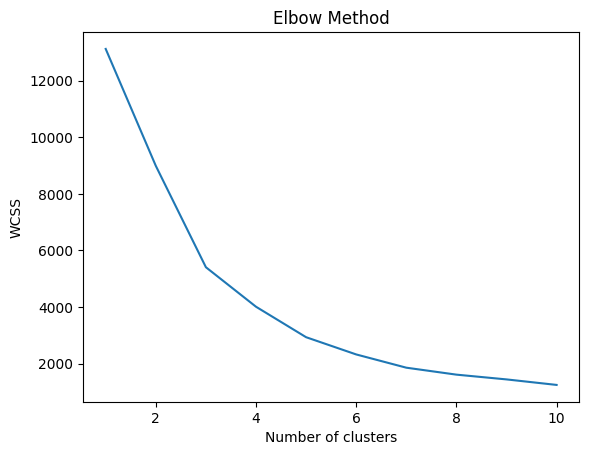

In [27]:
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [28]:
# Assume the elbow method suggests 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
purchase_behavior['cluster'] = kmeans.fit_predict(purchase_behavior_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
# Analyze cluster characteristics
cluster_analysis = purchase_behavior.groupby('cluster').mean()
print(cluster_analysis)

           total_spent  purchase_count      recency
cluster                                            
0          1952.625725      104.960123  4624.677301
1           463.590610       27.738182  4831.401818
2        118713.023333     2845.583333  4589.333333
